In [1]:
import cugraph
import cudf
import pandas as pd
import numpy as np

from graph_tool.all import *

/home/everything/applications/anaconda3/envs/rapidsai/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [2]:
data = pd.read_csv("/tmp/networks/medium.csv", dtype={'amount': object})

In [3]:
# create mapping from address to vertex id
column_values = data[["source", "target"]].values.ravel()
unique_values = pd.unique(column_values)
mapping = pd.DataFrame(unique_values).reset_index().rename(columns = {"index":"vertex",0:"address"} )

In [4]:
# create edge data based on vertex ids only
data_ids = data.merge(mapping.rename(columns={"address":"source"})).rename(columns = {"vertex":"source_id"})
data_ids = data_ids.merge(mapping.rename(columns={"address":"target"})).rename(columns = {"vertex":"target_id"})
data_ids = data_ids[["source_id", "target_id"]]
data_ids = cudf.DataFrame.from_pandas(data_ids)
data_ids

,source_id,target_id
0,0,1
1,9830,1
2,9830,1
3,9830,1
4,9884,1
...,...,...
20907,11266,11302
20908,4150,11303
20909,11184,11304
20910,1393,11305


In [5]:
# create a Graph using the source (src) and destination (dst) vertex pairs the GDF  
G = cugraph.Graph()
G.from_cudf_edgelist(data_ids, source='source_id', destination='target_id')

In [6]:
# run cugraph's force_atlas2 layout
layout = cugraph.layout.force_atlas2(G, max_iter=500,
                                     strong_gravity_mode=True,
                                     barnes_hut_theta=1.2,
                                     outbound_attraction_distribution=False,
                                     gravity=1,
                                     scaling_ratio=1)
layout = layout.to_pandas()
layout.head()

,x,y,vertex
0,-2.713495,186.139755,2707
1,7.583972,-131.458237,2755
2,130.426773,114.509895,2733
3,86.610153,-108.410591,2790
4,101.439209,34.509789,2710


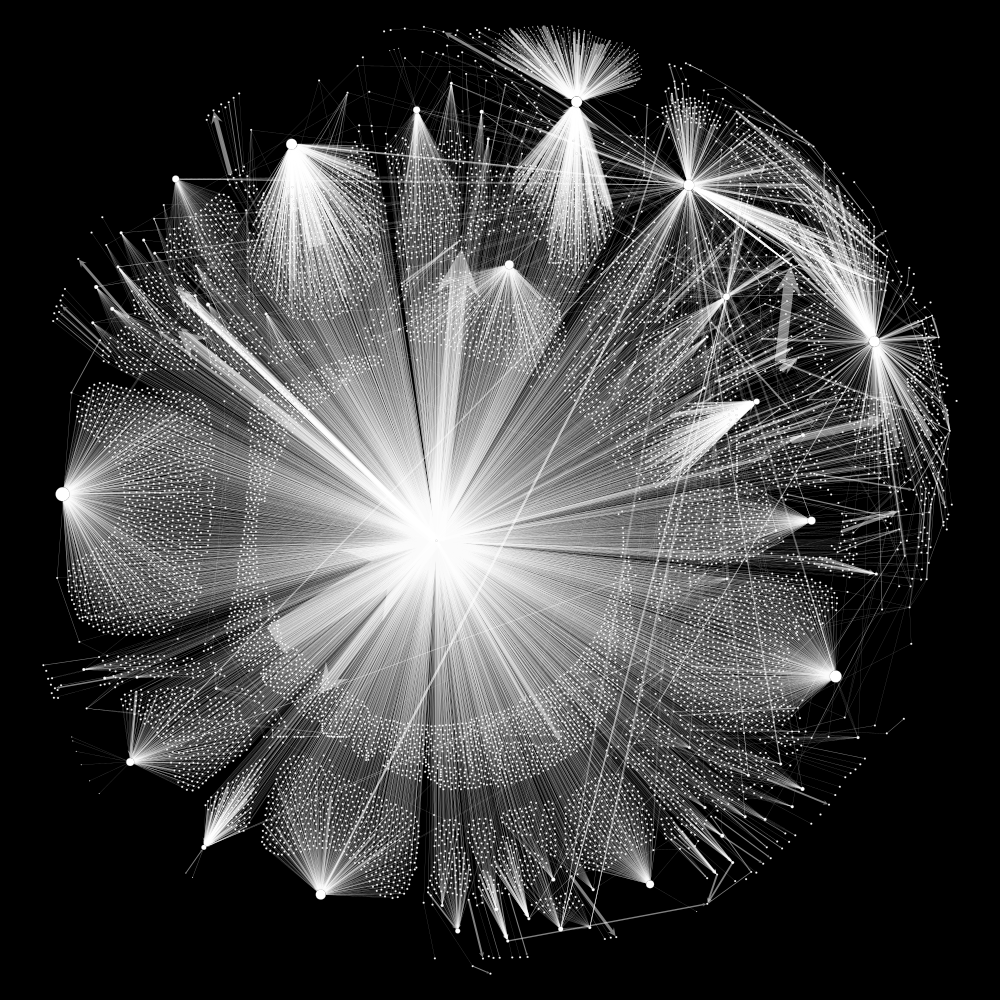

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd0c0a94a50, at 0x7fd0c0a94f50>

In [7]:
# plotting with graph-tool

g = Graph(directed=True)

# take the layout from cugraph and convert it to a graph-tool vertex property
vprop_double = g.new_vertex_property("vector<double>")
for i, row in enumerate(layout.sort_values("vertex")[["x", "y"]].values):
    vprop_double[i] = row

eweight = g.new_edge_property("string")
g.add_edge_list(data[["source", "target", "amount"]].values, hashed=True, eprops=[eweight])

# create an edge property representing edge width
esize = g.new_edge_property("float")
esize.a = list(map(lambda x: float(x), list(eweight)))
esize.a = (esize.a / (esize.a.max() / 1000.0))
esize.a = np.sqrt(esize.a)

# create a degree map for different vertex sizes based on vertex degree
deg = g.degree_property_map("in")
deg.a = 4 * (np.sqrt(deg.a) * 0.1 + 0.4)
    
graph_draw(g, pos=vprop_double,
           bg_color=[0,0,0,1],
           vertex_size=deg,
           vertex_fill_color=[1,1,1,1],
           edge_color=[1,1,1,0.5],
           edge_pen_width=esize,
           #output="/tmp/test.png",
           output_size=[1000, 1000])